In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [17]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
#     train_func= eeg_train
#     model.training_procedure(iteration=n_epochs,
#                                     train_dataloader=train_dataloader,
#                                      val_dataloader=val_dataloader,
#                                      print_cycle=2,
#                                      path=f"./dictionary/intermdiate_dicts",
#                                      loss_func=criterion,
#                                      optimiser=optimizer, #scheduler=scheduler,
#                                      train_func=train_func
#                                     )
#     if model.epoch == n_epochs+1:
#         EPOCH= n_epochs
#     else:
#         EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{EPOCH}.pt"
#            )
#     )

#     pickle.dump( model.return_IE_weights(), 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
#                )    

# OR
    model.load_state_dict(
    torch.load(
        open(
            os.path.join(
                saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{n_epochs}.pt"
            ), "rb"
        )
              )
    )
    pickle.load( 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
               )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


106 16

c0_acc 0.954954954954955 , c1_acc 0.32 , b_acc 0.6374774774774775
113 7

c0_acc 0.9826086956521739 , c1_acc 0.1320754716981132 , b_acc 0.5573420836751436
110 12

c0_acc 0.8943089430894309 , c1_acc 0.22641509433962265 , b_acc 0.5603620187145267
128 5

c0_acc 0.9770992366412213 , c1_acc 0.08928571428571429 , b_acc 0.5331924754634678
113 3

c0_acc 0.9658119658119658 , c1_acc 0.061224489795918366 , b_acc 0.5135182278039421
123 5

c0_acc 0.984 , c1_acc 0.1 , b_acc 0.542
108 18

c0_acc 0.864 , c1_acc 0.32142857142857145 , b_acc 0.5927142857142857
124 4

c0_acc 0.9841269841269841 , c1_acc 0.06779661016949153 , b_acc 0.5259617971482378
128 11

c0_acc 0.9624060150375939 , c1_acc 0.2 , b_acc 0.5812030075187969
128 7

c0_acc 0.9922480620155039 , c1_acc 0.11864406779661017 , b_acc 0.555446064906057
116 12

c0_acc 0.9747899159663865 , c1_acc 0.25 , b_acc 0.6123949579831933
120 26

c0_acc 0.9836065573770492 , c1_acc 0.48148148148148145 , b_acc 0.7325440194292653
115 14

c0_acc 0.934959349593

     accuracy  f1-score
S01  0.757764  0.722287
S02  0.714286  0.635844
S03  0.693182  0.653789
S04  0.711230  0.625298
S05  0.698795  0.608761
S06  0.731429  0.649833
S07  0.696133  0.672844
S08  0.691892  0.593049
S09  0.739362  0.684442
S10  0.718085  0.634054
S11  0.766467  0.719522
S12  0.829545  0.810729
S13  0.720670  0.676750
S14  0.701657  0.627460
S15  0.699454  0.627562
S16  0.704918  0.597549
S17  0.728916  0.696920
S19  0.679348  0.595342
S20  0.755556  0.692366


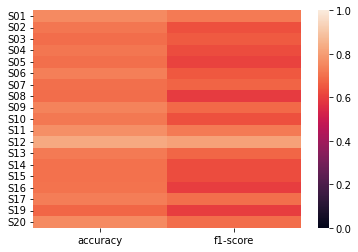

     class0 f1-score  class1 f1-score
S01         0.844622         0.450704
S02         0.824818         0.225806
S03         0.802920         0.307692
S04         0.825806         0.156250
S05         0.818841         0.107143
S06         0.839590         0.175439
S07         0.797048         0.395604
S08         0.813115         0.123077
S09         0.839344         0.309859
S10         0.828479         0.208955
S11         0.856089         0.380952
S12         0.888889         0.634146
S13         0.821429         0.358974
S14         0.816327         0.205882
S15         0.814815         0.202899
S16         0.824675         0.068966
S17         0.824903         0.400000
S19         0.802676         0.144928
S20         0.850340         0.333333


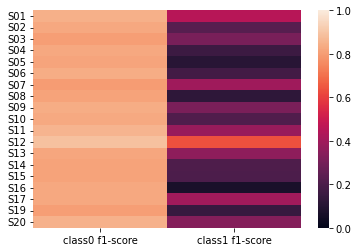

In [18]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
